In [1]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

In [2]:
# useful to generate SQL query
model_low_temp = ChatOllama(base_url="http://localhost:11434", model="qwen2.5:32b", temperature=0.1)
# useful to generate natural language outputs
model_high_temp = ChatOllama(base_url="http://localhost:11434", model="qwen2.5:32b", temperature=0.7)

In [3]:
class State(TypedDict):
    # to track conversation history
    messages: Annotated[list, add_messages]
    # input
    user_query: str
    # output
    sql_query: str
    sql_explanation: str

In [4]:
class Input(TypedDict):
    user_query: str

In [5]:
class Output(TypedDict):
    sql_query: str
    sql_explanation: str

In [6]:
generate_prompt = SystemMessage(
    "You are a helpful data analyst who generates SQL queries for users based on their questions."
)

In [7]:
def generate_sql(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "sql_query": res.content,
        # update conversation history
        "messages": [user_message, res],
    }

In [8]:
explain_prompt = SystemMessage(
    "You are a helpful data analyst who explains SQL queries to users."
)

def explain_sql(state: State) -> State:
    messages = [
        explain_prompt,
        # contains user's query and SQL query from prev step
        *state["messages"],
    ]
    res = model_high_temp.invoke(messages)
    return {
        "sql_explanation": res.content,
        # update conversation history
        "messages": res,
    }

In [9]:
builder = StateGraph(State, input=Input, output=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, "generate_sql")
builder.add_edge("generate_sql", "explain_sql")
builder.add_edge("explain_sql", END)

graph = builder.compile()

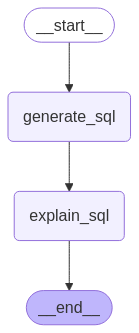

In [10]:
graph

In [11]:
graph.invoke({
  "user_query": "What is the total sales for each product?"
})

{'sql_query': 'To determine the total sales for each product, you would typically need a table that records sales transactions, often called something like `sales` or `transactions`. This table should have at least two columns: one for the product (e.g., `product_id` or `product_name`) and another for the quantity sold or the sale amount (e.g., `quantity`, `sale_amount`, etc.).\n\nHere is a basic SQL query that calculates total sales for each product assuming you have a table named `sales` with columns `product_id` and `sale_amount`:\n\n```sql\nSELECT \n    product_id, \n    SUM(sale_amount) AS total_sales\nFROM \n    sales\nGROUP BY \n    product_id;\n```\n\nIf your table uses different column names or structures, please provide more details so I can adjust the query accordingly.',
 'sql_explanation': ''}